# rounD (LevelX)

## About

The rounD dataset was created and published by a team from the Institute for Automotive Engineering (ika) of RWTH Aachen University to promote research in many different domains of mobility. The dataset can therefore be downloaded and used free of charge for academic and research purposes.

This dataset contains a total of six hours of recordings with more than 13,746 road users including cars, vans, trucks, buses, pedestrians, bicycles and motorcycles from three roundabouts.

### How to Apply Dataset

The rounD dataset is free for non-commercial use only. According to the license and protocols, as a third-party, we cannot share any form of this dataset online. Please visit [the official website](https://levelxdata.com/round-dataset/) of rounD, fill in the application form and send your request.

The maps of rounD dataset are manually created by Tactics2D, in the format of OpenStreetMap (OSM), labeled in Lanelet2 style. The maps are stored in `data/rounD_map`. You can download them from [here](https://github.com/WoodOxen/tactics2d/tree/master/tactics2d/data/rounD_data)

### Citation

```latex
@inproceedings{rounD,
    title={The rounD Dataset: A Drone Dataset of Road User Trajectories at Roundabouts in Germany},
    author={Krajewski, Robert and Moers, Tobias and Bock, Julian and Vater, Lennart and Eckstein, Lutz},
    booktitle={2020 IEEE 23rd International Conference on Intelligent Transportation Systems (ITSC)},
    pages={1-6},
    year={2020},
    doi={10.1109/ITSC45102.2020.9294728}
}
```

## Data Analysis

> This part is independently conducted by Tactics2D.

According to meta records:

- Trajectory data files 00 are recorded in location 1 (denoted as rounD_1)
- Trajectory data files 01 are recorded in location 2 (denoted as rounD_2)
- Trajectory data files 03-23 are recorded in location 0 (denoted as rounD_0). Among them, files 03-08 are recorded in region 0 and files 09-23 are recorded in region 1.

![](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/rounD-locations.png)

In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig(level=logging.WARNING)

import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting up parameters for matplotlib
mpl.rcParams.update(
    {
        "figure.dpi": 200,  # 200 for high quality
        "font.family": "DejaVu Sans Mono",
        "font.size": 6,
        "font.stretch": "semi-expanded",
        "animation.html": "jshtml",
        "animation.embed_limit": 5000,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#cccccc",
        "axes.facecolor": "white",
    }
)
sns.set_palette("Set2")

In [3]:
locations = dict()
dfs_meta = pd.DataFrame()
for i in range(24):
    df_meta = pd.read_csv("../../data/rounD/data/%02d_recordingMeta.csv" % i)
    locations[i] = df_meta["locationId"][0]
    dfs_meta = pd.concat([dfs_meta, df_meta], ignore_index=True)

In [4]:
dfs_track_meta = pd.DataFrame()
for i in range(24):
    df_track_meta = pd.read_csv("../../data/rounD/data/%02d_tracksMeta.csv" % i)
    df_track_meta["locationId"] = locations[i]
    df_track_meta["fileId"] = i
    dfs_track_meta = pd.concat([dfs_track_meta, df_track_meta], ignore_index=True)

### Distribution of Trajectory on Map

The projection of trajectories onto the map reveals that the majority of road users in the rounD dataset are cars. The vehicle trajectories exhibit behavior that aligns with typical driving patterns.

![Trajectories on map](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/rounD.png)

### Distribution of Trajectory Categories

The distribution of trajectory categories exhibits substantial variation across different locations. At a single location, the proportion of vehicle trajectories also fluctuates over time or between samples.

In [5]:
dfs = [pl.DataFrame()] * 3

for i in range(24):
    df = pl.read_csv("../../data/rounD/data/%02d_tracks.csv" % i)
    df = df.select(["trackId", "frame", "xCenter", "yCenter", "heading", "xVelocity", "yVelocity"])
    df = df.with_columns(pl.lit(i).alias("fileId"))
    df = df.join(
        pl.DataFrame(dfs_track_meta)[["fileId", "trackId", "class"]],
        on=["fileId", "trackId"],
        how="left",
    )

    dfs[locations[i]] = pl.concat([dfs[locations[i]], df])

In [6]:
for i in range(3):
    x_min = np.floor(dfs[i]["xCenter"].min())
    x_max = np.ceil(dfs[i]["xCenter"].max())
    y_min = np.floor((-dfs[i]["yCenter"]).min())
    y_max = np.ceil((-dfs[i]["yCenter"]).max())
    vx = dfs[i]["xVelocity"].to_numpy()
    vy = dfs[i]["yVelocity"].to_numpy()

    x_edges = np.linspace(x_min, x_max, num=int((x_max - x_min) * 10 + 1), endpoint=True)
    y_edges = np.linspace(y_min, y_max, num=int((y_max - y_min) * 10 + 1), endpoint=True)
    x_bin = np.digitize(dfs[i]["xCenter"].to_numpy(), x_edges) - 1
    y_bin = np.digitize((-dfs[i]["yCenter"]).to_numpy(), y_edges) - 1
    speed = np.sqrt(vx**2 + vy**2)

    dfs[i] = dfs[i].with_columns(
        [pl.Series("x_bin", x_bin), pl.Series("y_bin", y_bin), pl.Series("speed (m/s)", speed)]
    )

In [7]:
dfs_meta["vehicle_ratio"] = dfs_meta["numVehicles"] / dfs_meta["numTracks"]
dfs_meta["locationId"] = pd.Categorical(dfs_meta["locationId"], categories=[0, 1, 2], ordered=True)

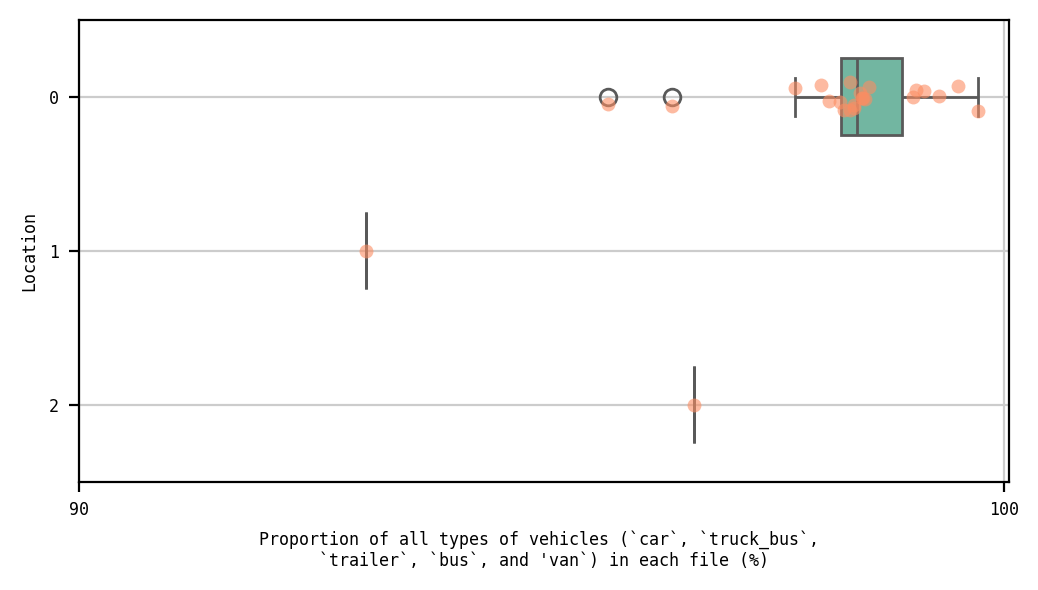

In [8]:
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(data=dfs_meta, x="vehicle_ratio", y="locationId", width=0.5, ax=ax)

sns.stripplot(data=dfs_meta, x="vehicle_ratio", y="locationId", alpha=0.6, ax=ax)

ax.set_xticks([0.9, 1.0])
ax.set_xticklabels(["90", "100"])
ax.yaxis.grid(True)
ax.set_xlabel(
    "Proportion of all types of vehicles (`car`, `truck_bus`, \n`trailer`, `bus`, and 'van`) in each file (%)"
)
ax.set_ylabel("Location")
plt.show()

### Distribution of Average Speed on Map

The average speed in the roundabout scenario is higher than at intersections but lower than on highways. Before entering the roundabout, vehicles typically travel at an average speed of around 15 m/s (54 km/h). Once inside the roundabout, the speed decreases to approximately 7.5 m/s (27 km/h). The lowest speeds are observed at the entry points, indicating significant deceleration, while vehicles tend to accelerate again upon exiting the roundabout.

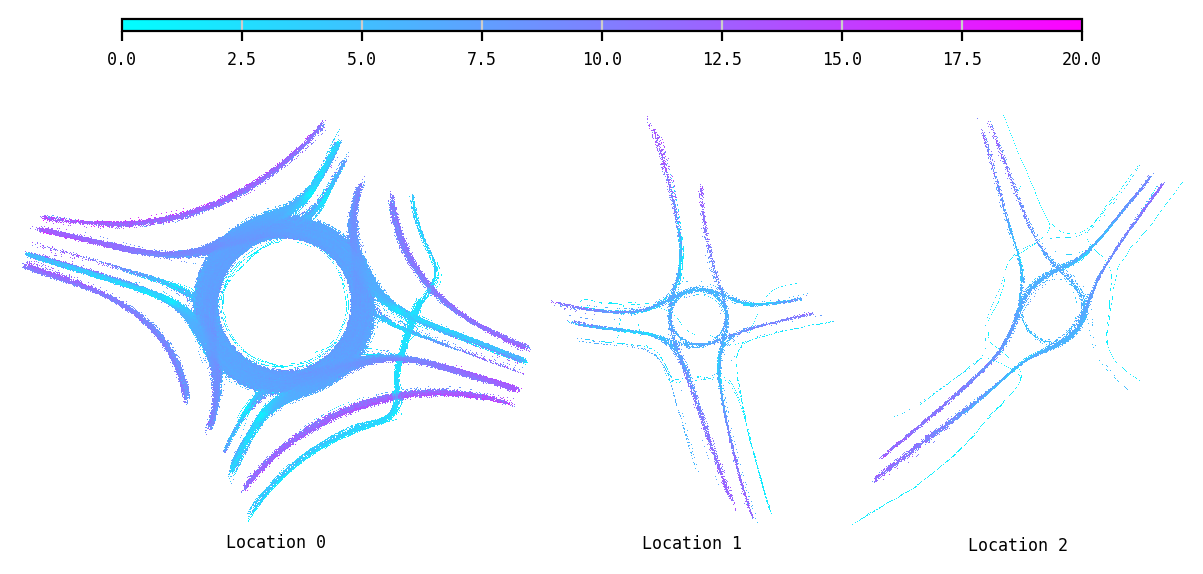

In [9]:
fig = plt.figure(figsize=(6, 3))
gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1.17, 0.65, 0.76])

axes = []
for i in range(3):
    ax = fig.add_subplot(gs[0, i])
    df_speed_heatmap = (
        dfs[i]
        .group_by(["y_bin", "x_bin"])
        .agg(pl.col("speed (m/s)").mean().alias("avg_speed"))
        .sort(["y_bin", "x_bin"])
    ).to_pandas()
    grid = df_speed_heatmap.pivot(index="y_bin", columns="x_bin", values="avg_speed")
    hm = sns.heatmap(
        grid, ax=ax, cmap="cool", cbar=False, xticklabels=False, yticklabels=False, vmin=0, vmax=20
    )

    ax.set_aspect("equal")
    ax.set_xlabel(f"Location {i}", rotation=0)
    ax.set_ylabel("")

    axes.append(ax)

cbar_ax = fig.add_axes([0.1, 0.94, 0.8, 0.02])
cbar = fig.colorbar(hm.get_children()[0], cax=cbar_ax, orientation="horizontal")

plt.tight_layout(rect=[0.0, 0.0, 1, 0.92])
plt.show()

### Distribution of Speed by Trajectory Type

The peak of the speed distribution differs across trajectory types. Cars consistently exhibit the highest speed peaks, while pedestrians show the lowest. Additionally, the peak speed for each type varies depending on the location.

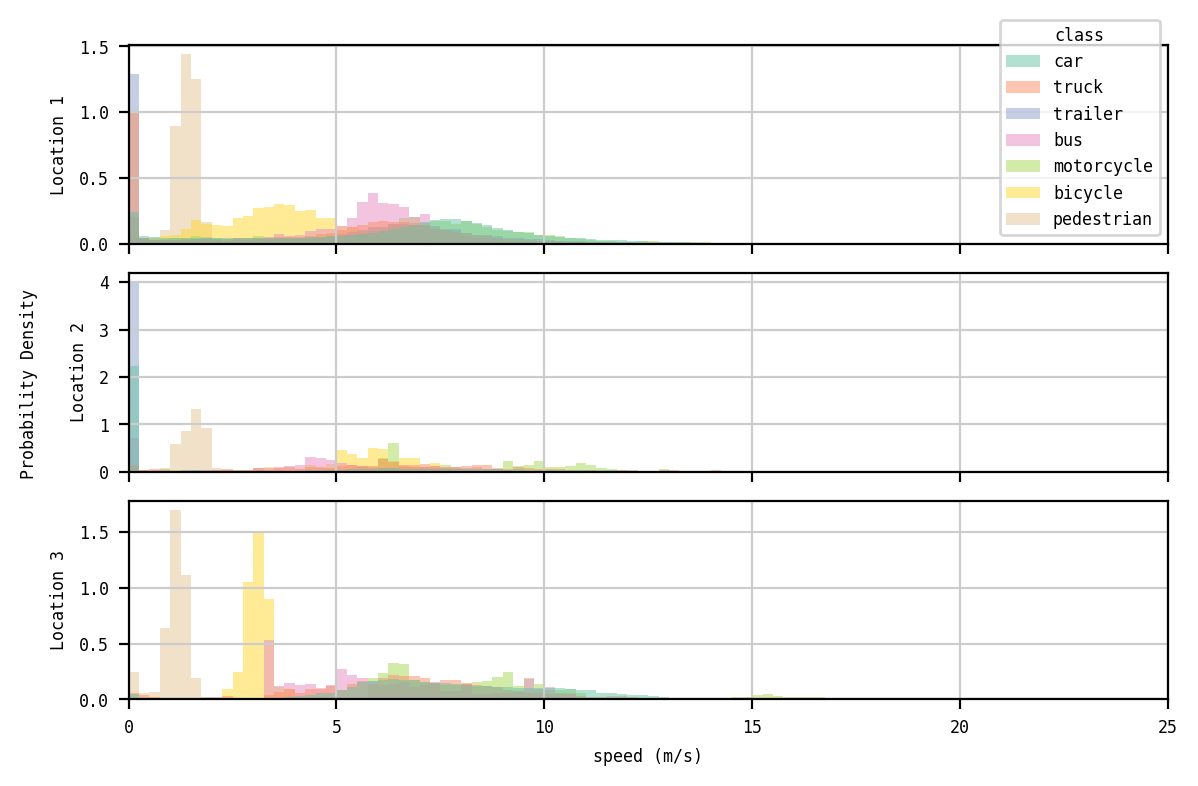

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
for i in range(3):
    df_speed = dfs[i].to_pandas()

    sns.histplot(
        df_speed,
        x="speed (m/s)",
        hue="class",
        hue_order=["car", "truck", "trailer", "bus", "motorcycle", "bicycle", "pedestrian"],
        multiple="layer",
        palette="Set2",
        ax=axes[i],
        stat="density",
        common_norm=False,
        binwidth=0.25,
        binrange=(0, 25),
        linewidth=0,
        alpha=0.5,
        legend=(i == 0),
    )

    axes[i].set_xlim([0, 25])
    axes[i].set_ylabel(f"Location {i+1}")

fig.text(0.02, 0.5, "Probability Density", va="center", rotation="vertical")

fig.tight_layout(rect=[0.03, 0, 1, 1])
plt.show()

## Tactics2D Integration

This section explains how to parse and replay logs from the rounD dataset by Tactics2D.

### Dataset Preparation

You can place the rounD dataset in any directory of your choice. However, it’s important to maintain the following folder structure for compatibility:

```shell
rounD
├── data
│   ├── 01_highway.png
│   ├── 01_recordingMeta.csv
│   ├── 01_tracks.csv
│   ├── 01_tracksMeta.csv
│   ├── ...
```

### Class Mapping

The table below illustrates how classes from the rounD dataset are mapped to corresponding traffic participants in the Tactics2D framework. 

| Class | Tactics2D |
| --- | --- |
| car | `tactics2d.participant.element.Vehicle` |
| truck | `tactics2d.participant.element.Vehicle` |
| trailer | `tactics2d.participant.element.Vehicle` |
| bus | `tactics2d.participant.element.Vehicle` |
| motorcycle | `tactics2d.participant.element.Cyclist`|
| bicycle | `tactics2d.participant.element.Cyclist`|
| pedestrian | `tactics2d.participant.element.Pedestrian` |

### Parse and Replay Logs

To parse, replay, and visualize the rounD dataset using Tactics2D, you can use the following code snippet:

In [11]:
%matplotlib notebook

import os
import numpy as np
from matplotlib.animation import FuncAnimation
from shapely.geometry import Point
from IPython.display import HTML

from tactics2d.dataset_parser import LevelXParser
from tactics2d.map.parser import OSMParser
from tactics2d.map.map_config import ROUND_MAP_CONFIG
from tactics2d.sensor import BEVCamera
from tactics2d.renderer import MatplotlibRenderer

Specify the path to the dataset and the map, and then run the following code:

In [12]:
dataset_path = "../../data/rounD/data"  # Replace with your dataset path
map_path = "../../data/rounD_map"  # Replace with your map path
dataset_parser = LevelXParser("rounD")
map_parser = OSMParser(lanelet2=True)

For simplicity, we revise a function from the `ScenarioManager` to handle the parsing and replaying of the rounD dataset:

In [13]:
def render_levelx(map_, participants, map_boundary, stamp_range, resolution):
    x_min, x_max, y_min, y_max = map_boundary
    camera_position = np.array([0, 0])
    camera = BEVCamera(id_=0, map_=map_)

    renderer = MatplotlibRenderer(xlim=(x_min, x_max), ylim=(y_min, y_max), resolution=resolution)

    fig = renderer.fig  # Use the one already created
    frame_list = list(range(stamp_range[0], stamp_range[1], 40))
    prev_road_id_set = set()
    prev_participant_id_set = set()

    def update(frame):
        nonlocal prev_road_id_set, prev_participant_id_set

        participant_ids = [pid for pid, p in participants.items() if p.is_active(frame)]

        geometry_data, prev_road_id_set, prev_participant_id_set = camera.update(
            frame,
            participants,
            participant_ids,
            prev_road_id_set,
            prev_participant_id_set,
            Point(camera_position),
        )

        renderer.update(geometry_data, camera_position)
        renderer.ax.set_title(f"Frame: {frame}")

    ani = FuncAnimation(fig, update, frames=frame_list, interval=40, repeat=True)
    return ani

In [14]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=2, folder=dataset_path, stamp_range=(0, 10000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "rounD_0.osm"), configs=ROUND_MAP_CONFIG["rounD_0"]
)

print(f"Map boundary of RounD location 0: {map_.boundary}.")

boundary = (
    map_.boundary[0] + 80, map_.boundary[1] - 80,
    map_.boundary[2] + 50, map_.boundary[3] - 50
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range, resolution=(2000, 1000))
HTML(ani.to_html5_video())

Map boundary of RounD location 0: (np.float64(-75.0), np.float64(230.0), np.float64(-143.0), np.float64(43.0)).


In the same way, we display the log in other locations in rounD.

In [15]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=0, folder=dataset_path, stamp_range=(10000, 20000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "rounD_1.osm"), configs=ROUND_MAP_CONFIG["rounD_1"]
)

print(f"Map boundary of RounD location 1: {map_.boundary}.")

boundary = (
    map_.boundary[0] + 120, map_.boundary[1] - 50,
    map_.boundary[2] + 80, map_.boundary[3] - 110
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range, resolution=(2000, 1000))
HTML(ani.to_html5_video())

Map boundary of RounD location 1: (np.float64(-62.0), np.float64(212.0), np.float64(-232.0), np.float64(65.0)).


In [16]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=1, folder=dataset_path, stamp_range=(20000, 30000)
)
map_ = map_parser.parse(
    file_path=os.path.join(map_path, "rounD_2.osm"), configs=ROUND_MAP_CONFIG["rounD_2"]
)

print(f"Map boundary of RounD location 2: {map_.boundary}.")

boundary = (
    map_.boundary[0] + 50, map_.boundary[1] - 30,
    map_.boundary[2] + 40, map_.boundary[3] - 40
)

ani = render_levelx(map_, participants, boundary, actual_stamp_range, resolution=(2000, 1000))
HTML(ani.to_html5_video())

Map boundary of RounD location 2: (np.float64(26.0), np.float64(217.0), np.float64(-155.0), np.float64(36.0)).


## Appendix: Data Format

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        This is a backup copy of 
        <a href="https://levelxdata.com/wp-content/uploads/2024/03/rounD-Format.pdf" target="_blank" rel="noopener noreferrer">
            the official documentation
        </a>, provided here for reference purposes only.
    </p>
</div>

The dataset includes measurement data extracted from one or more recording sites (locations) in the data directory as well as map files per location in the maps directory (if part of the dataset). Data and maps can be associated using a recording's location id. The data for each location is split into multiple continuous recordings.

In total four files are provided for each recording:

- An image of the recorded road section (XX_background.png)
- A csv file describing the recording location (XX_recordingsMeta.csv)
- A csv file containing an overview of recorded vehicle and VRU tracks (XX_tracksMeta.csv)
- A csv file for the tracks' trajectories (XX_tracks.csv)
    These files are created for each recording to ensure easy handling of the data.

In addition the following map data for each recording location are provided:

- Lanelet2 maps (.osm)
- ASAM OpenDrive maps (.xodr)
- 3D scene (.osgb & .fbx)

In the following, the dataset format and especially the meaning of every column is explained in
detail.

Please note that we summarize pedestrians, bicyclists and motorcycles to vulnerable road users
(VRUs) in the following tables.

### Image of the Road Section

For each recording a georeferenced image of the road section is added.The image is based on the recording itself by removing all moving vehicles through filtering. Additionally the resolution of the image was reduced.

### Recording Meta Information

This file contains metadata for each recording. The metadata provides a general overview, e.g. of the time of recording, the road section considered and the total number of objects tracked.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| locationId | The id of the recording location. | [-] | 
| frameRate | The frame rate which was used to record the video. | [hz] |
| speedLimit | The speed limit of the driving lanes. In all recordings, the speed limit is the same for every driving lane. | [m/s] |
| weekday | The weekday the recording was done. | [-] |
| startTime | The hour at which the recording was started | [hh] |
| duration | The duration of the recording. | [s] |
| numTracks | The number of objects tracked. | [-] |
| numVehicles | The number of vehicles tracked. | [-] |
| numVrus | The number of vulnerable road users (VRUs) tracked. | [-] |
| latLocation | Rough latitude coordinates of recording location. Not to be confused with UTM coordinates! | [deg] |
| lonLocation | Rough longitude coordinates of recording location. Not to be confused with UTM coordinates! | [deg] |
| xUtmOrigin | X value of UTM coordinate of origin of the local coordinate system for this recording location. Add this to xCenter to get UTM coordinates. | [m] |
| yUtmOrigin | Y value of UTM coordinate of origin of the local coordinate system for this recording location. Add this to yCenter to get UTM coordinates. | [m] |
| orthoPxToMeter | Scale factor from ortho image pixels to UTM meters. This value is needed for visualization. | [m/px] |
| exportVersion | Version of data format. (may be missing in some datasets) | [-] |

### Track Meta Information

This file contains an overview of all tracks.

The purpose of this file is to allow filtering tracks e.g. by class.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| trackId | The id of the track. The ids are assigned in ascending order for each recording. | [-] |
| initialFrame | The frame in which the track starts. | [-] |
| finalFrame | The frame in which the track ends. | [-] |
| numFrames | The total lifetime in frames. | [-] |
| width | The width of the tracked object. This property is set to zero for VRUs. | [m] |
| length | The length of the tracked object. This property is set to zero for VRUs. | [m] |
| class | The class of the tracked object. | [-] |

### Tracks

This file contains all time dependent values for each track. Information such as current position, velocity and acceleration.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The id of the recording. Every recording has a unique id. | [-] |
| trackId | The track's id. The ids are assigned in ascending order for each recording. | [-] |
| frame | The frame for which the information are given. | [-] |
| trackLifetime | The current age of the track at this frame. | [-] |
| xCenter | The x position of the object's centroid in the local coordinate system. Add xUtmOrigin to get UTM coordinates. | [m] |
| yCenter | The y position of the object's centroid in the local coordinate system. Add yUtmOrigin to get UTM coordinates. | [m] |
| heading | The heading in the local coordinate system. | [deg] |
| width | The width of the object. This property is set to zero for VRUs. | [m] |
| length | The height of the object. This property is set to zero for VRUs. | [m] |
| xVelocity | The velocity in x-axis direction in the local coordinate system. | [m/s] |
| yVelocity | The velocity in y-axis direction in the local coordinate system. | [m/s] |
| xAcceleration | The acceleration in x-axis direction in the local coordinate system. | [m/s²] |
| yAcceleration | The acceleration in y-axis direction in the local coordinate system. | [m/s²] |
| lonVelocity | The longitudinal velocity. | [m/s] |
| latVelocity | The lateral velocity. | [m/s] |
| lonAcceleration | The longitudinal acceleration. | [m/s²] |
| latAcceleration | The lateral acceleration. | [m/s²] |

### Coordinate System

The global coordinate system used is the UTM coordinate system, as we geo-referenced our data. For easier handling of data of the same intersection in different recordings, we introduced a local UTM-like coordinate system.

The only difference is, that the origin (0, 0) is very close to the recorded road section and the same for all recordings at each location.

To transform positions into the global UTM coordinate system, just add xUtmOrigin and yUtmOrigin to all positions.

The local coordinate system looks as follows: The horizontal axis is the x-axis, which grows to the right.

The vertical axis is the y-axis, which grows upwards.

The heading is calcuated as in the UTM coordinate system.

Finally, we use SI units only.

![The coordinate system of uniD dataset](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/inD-coordinate-system.png)